In [1]:
# default_exp capsAnalaysis

In [2]:
import sys

In [3]:
sys.path.append('/workspace/oct_ca_seg/oct/')

In [4]:
from oct.startup import *
from model import CapsNet
import numpy as np
import mlflow
from fastai.vision import *
import mlflow.pytorch as MLPY
from fastai.utils.mem import gpu_mem_get_all
from skimage import filters

In [5]:
gpu_mem_get_all()

[GPUMemory(total=16280, free=16270, used=10)]

In [6]:
cocodata_path = Path('/workspace/oct_ca_seg/COCOdata/')
train_path = cocodata_path/'train/images'
valid_path = cocodata_path/'valid/images'
test_path = cocodata_path/'test/images'

In [7]:
metrics = [sens, spec, dice, my_Dice_Loss, acc]

In [8]:
runsave_dir = Path('/workspace/oct_ca_seg/runsaves/')

In [9]:
run_name = 'DEEPCAP_0001_30_learnersaved'
cfg_file = 'configCAPS_APPresnet18_bs16_epochs15_lr0.001.json'

In [10]:
run_name = 'DEEPCAP_0001_30_small_learnersaved'
cfg_file = 'configCAPS_small_bs24_epochs30_lr0.001.json'

In [11]:
run_name = 'DEEPCAP_0001_30_smooth_small_learnersaved' # i put blurring in the finer detai parts of the model leading to poorly demarcated labels
cfg_file = 'configCAPS_small_bs24_epochs30_lr0.001.json'

In [12]:
run_dir = runsave_dir/run_name

In [17]:
def loadConfigRun(run_dir, name):
    with open(run_dir/name, 'r') as file:
        return json.load(file)

In [18]:
cfg_dict = loadConfigRun(run_dir, cfg_file)

In [19]:
config = DeepConfig(cfg_dict)

## Train, Valid

In [20]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(cocodata_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_folder('train', 'valid')
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size=config.LEARNER.img_size)
data = src.databunch(cocodata_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = [torch.tensor([0.2190, 0.1984, 0.1928]), torch.tensor([0.0645, 0.0473, 0.0434])]
data.normalize(stats);
data.c_in, data.c_out = 3, 2

## Test

In [123]:
fn_get_y = lambda image_name: Path(image_name).parent.parent/('labels/'+Path(image_name).name)
codes = np.loadtxt(cocodata_path/'codes.txt', dtype=str)
tfms = get_transforms()
src = (SegCustomItemList
       .from_folder(test_path, recurse=True, extensions='.jpg')
       .filter_by_func(lambda fname: Path(fname).parent.name == 'images', )
       .split_by_rand_pct(0.90)
       .label_from_func(fn_get_y, classes=codes))
src.transform(tfms, tfm_y=True, size =config.LEARNER.img_size)
data = src.databunch(test_path,
                     bs=config.LEARNER.bs,
                     val_bs=2*config.LEARNER.bs,
                     num_workers = config.LEARNER.num_workers)
stats = data.batch_stats()
data.normalize(stats);
data.c_in, data.c_out = 3, 2

In [22]:
deepCap = CapsNet(config.MODEL).cuda()
learn = Learner(data = data,
                  model = deepCap,
                  metrics = metrics)

In [23]:
lr_find(learn)

epoch,train_loss,valid_loss,sens,spec,dice,my_Dice_Loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


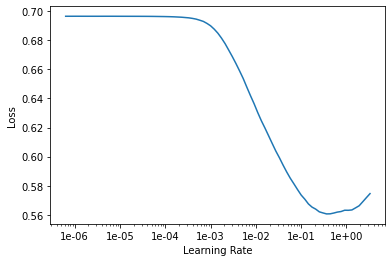

In [24]:
learn.recorder.plot()

In [125]:
learn = learn.load(run_dir/'learner')

In [126]:
class Analysis():
    def __init__(self, learner:Learner, run_dir:Path):
        self.learner = learner
        self.run_dir = run_dir
        self.metrics = pd.read_json(self.run_dir/'metrics.json')
        self.trainL =  pd.read_json(self.run_dir/'trainL.json')
        self.validL =  pd.read_json(self.run_dir/'validL.json')
    
    def remove0FromMetric(self, metric):
        zero_dict = {k:v for (k,v) in self.results[metric].items() if v==0}
        zero_dict = {k: v for k, v in sorted(zero_dict.items(), key=lambda item: item[1])}
        new_dict = {k:v for (k,v) in self.results[metric].items() if v!=0}
        new_dict = {k: v for k, v in sorted(new_dict.items(), key=lambda item: item[1])}
        print('there were ', len(zero_dict.keys()), 'zeros in the ', metric,' list.')
        return zero_dict, new_dict
    
    def histPlotMetric(self, metric, save=False):
        #metric = one of 'dices', 'sens', 'specs', 'accs' 
        zeros, actual = self.remove0FromMetric(metric)
        l_actual = list(actual.values())
        l_actual = [x for x in l_actual if x==x] # get rid of nans
        mean, std, median, max, min = np.mean(l_actual), np.std(l_actual), np.median(l_actual), np.max(l_actual), np.min(l_actual)
        print(mean, std, median, max, min)
        plt.hist(l_actual)
        if save: plt.savefig(self.checkpoint_path/(metric+'.png'))
        #return l_actual
    
    def showPrediction(self, id):
        batch = self.learner.data.one_batch(ds_type=DatasetType.Valid)
        xb = batch[0][id]#.permute(1,2,0).cpu()
        yb = batch[1][id][0]#.permute(1,2,0).cpu()
        pb = self.learner.model(xb.unsqueeze(0).cuda())[0]
        #print(xb.size(), yb.size(), pb.size())
        fig, (axim, axl, axp) = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5),
                    subplot_kw={'xticks': [], 'yticks': []})
        #images
        im = axim.imshow(xb.cpu().permute(1,2,0))
        axim.set_title('Image')
        l = axl.imshow(yb.cpu())
        axl.set_title('Label')
        p = axp.imshow(pb.detach().cpu()[1])
        axp.set_title('Pred')
        
        #return xb.size(), yb.size(), pb.size()

In [127]:
CapsAnalysis = Analysis(learn, run_dir)

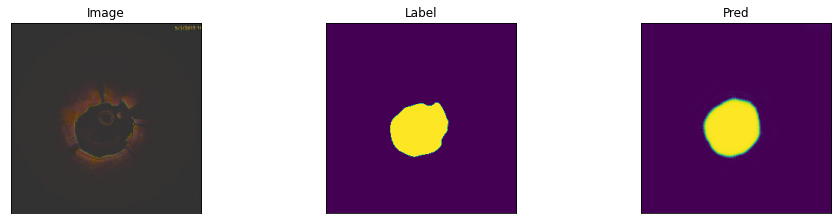

In [128]:
CapsAnalysis.showPrediction(27)

In [118]:
preds = learn.model(data.one_batch(ds_type=DatasetType.Valid)[0].cuda()).detach().cpu()

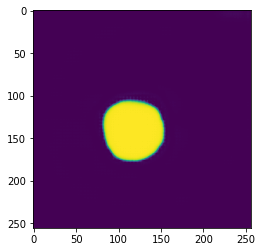

In [29]:
plt.imshow(preds[2][1])

In [58]:
data.one_batch(ds_type=DatasetType.Valid)[1].size()

torch.Size([48, 1, 256, 256])

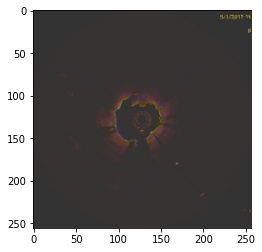

In [52]:
plt.imshow(x[1])

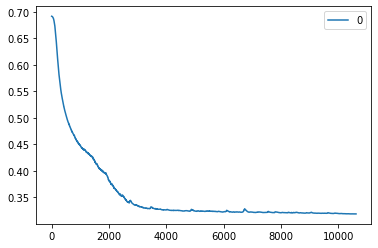

In [41]:
CapsAnalysis.trainL.sort_index().plot.line()

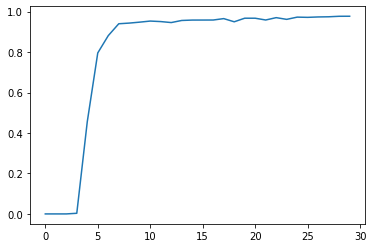

In [42]:
CapsAnalysis.metrics['dice'].sort_index().plot.line()

In [ ]:
def freeze_to(learn, n): # freeze model up to layer n
    for i, param in enumerate(learn.model.parameters()):
        if i<n: param.requires_grad=False

In [ ]:
learn.unfreeze()

In [ ]:
freeze_to(learn, 60)

In [ ]:
for i, param in enumerate(learn.model.parameters()):
    print(i,param.requires_grad)

In [ ]:
learn.opt.clear()

In [ ]:
learner.fit_one_cycle(2, max_lr=slice(0.00001), wd=0.01, pct_start=0.3)